In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 64

## Data

In [7]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations')]

In [11]:
path_imgs = path/'images'
path_annot = path/'annotations'

In [35]:
path_imgs.ls()[:3]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_100.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_82.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_180.jpg')]

In [12]:
path_annot.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/test.txt'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/README')]

## Create ImageDataBunch
1. How to get training data inputs    -> ItemList
2. How to split it into train/val subsets -> ItemLists (Train, Valid, Test=None)
3. How get training data targets -> LabelLists
4. [Add a test set]
5. [What transformations to apply]
6. Create a DataBunch

In [ ]:
get_t

In [56]:
np.random.seed(42)
db = (ImageList.from_folder(path_imgs)
     .split_by_rand_pct()
     .label_from_re(r'.*\/(.*)_\d*\.jpg')
     .transform(tfms=get_transforms(), size=224)
     .databunch(bs=bs)
     .normalize(imagenet_stats));db

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bengal,staffordshire_bull_terrier,german_shorthaired,english_setter,english_setter
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,keeshond,Abyssinian,samoyed,chihuahua
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Test: None

In [45]:
db.c

37

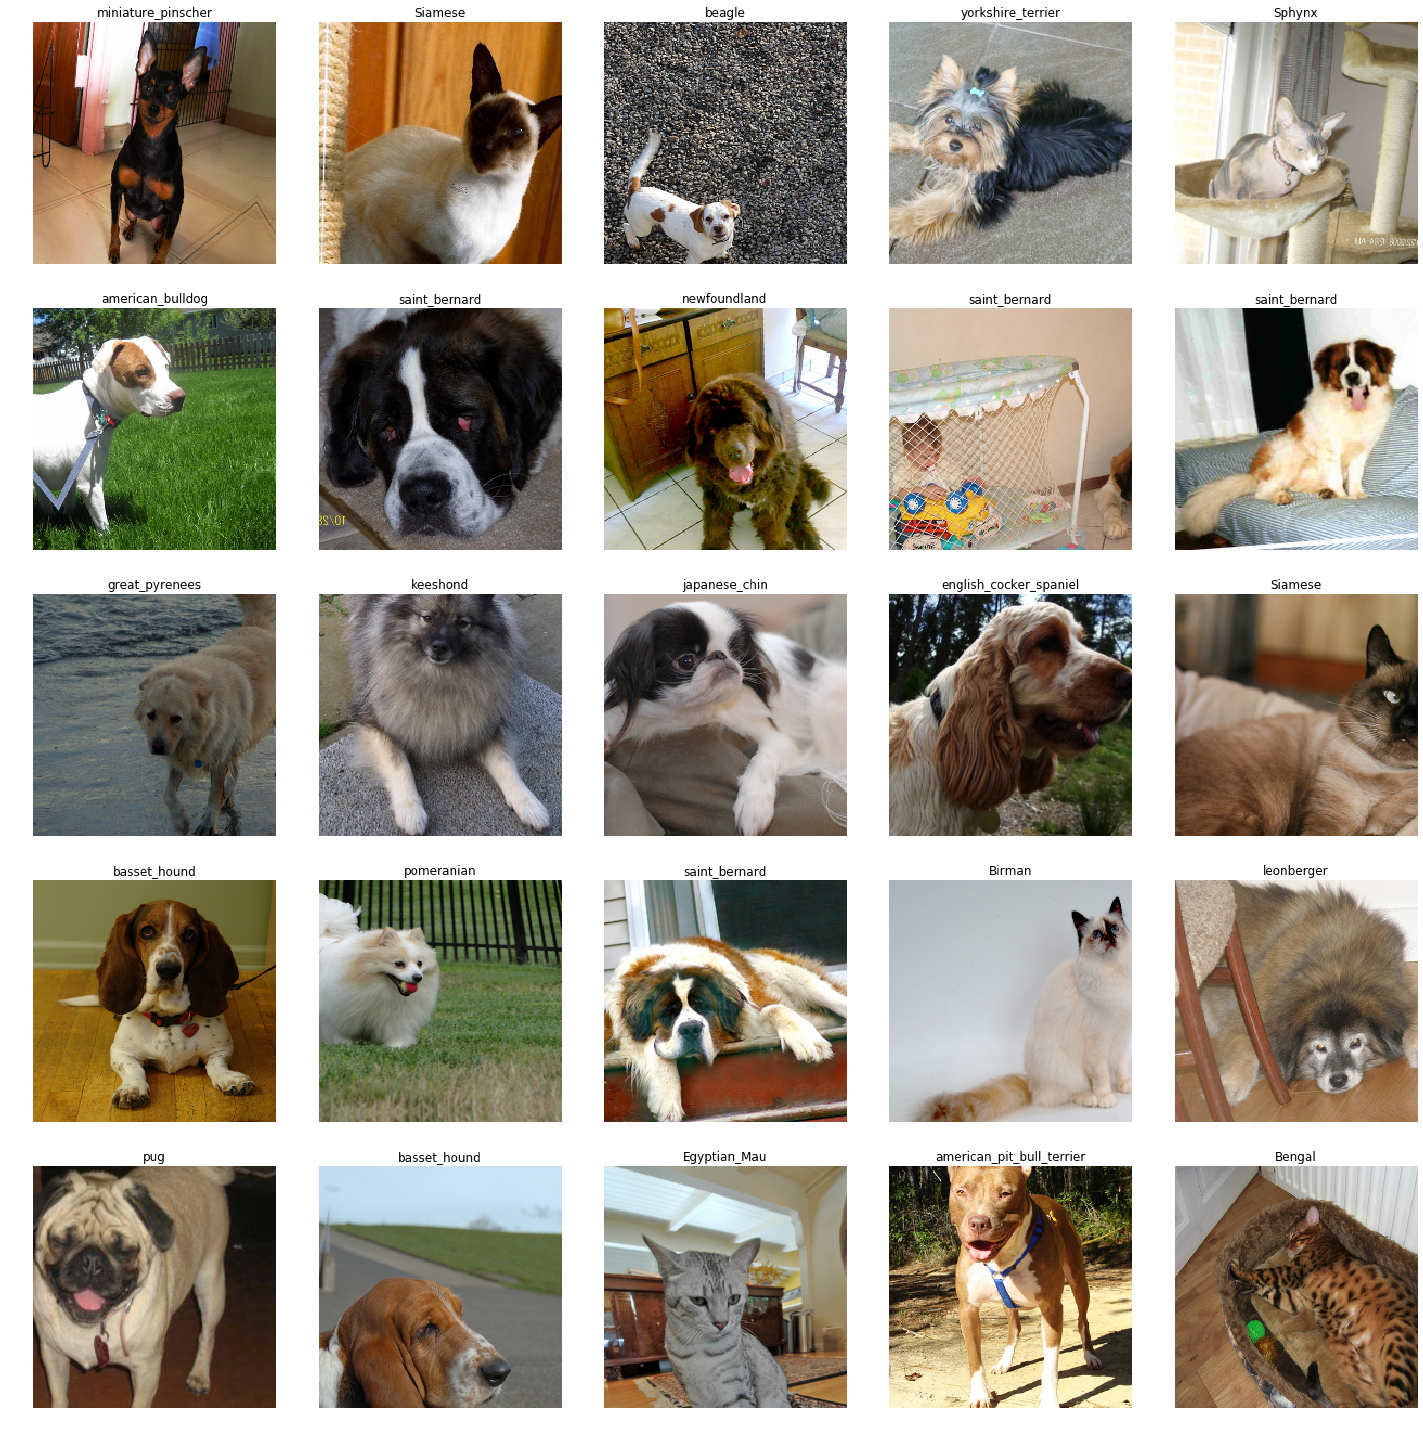

In [46]:
db.show_batch(rows=3)

## Training - Resnet 34

In [57]:
learn = cnn_learner(db, models.resnet34, metrics=[accuracy])

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


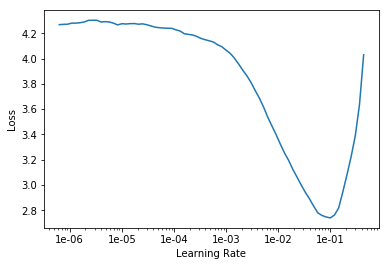

In [49]:
learn.recorder.plot()

In [50]:
lr = 1e-2
learn.fit_one_cycle(4, lr)

In [53]:
learn.save('r34-stage1')

### Unfreeze

In [65]:
learn.load('r34-stage1');

In [66]:
learn.unfreeze()

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


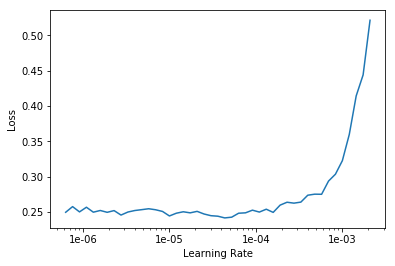

In [68]:
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(4, slice(1e-5, lr/10))

In [70]:
learn.fit_one_cycle(4, slice(1e-5, lr/100))

In [71]:
learn.save('r34-stage2')

## Results

In [73]:
interp = ClassificationInterpretation.from_learner(learn)

In [79]:
losses, idxs = interp.top_losses()

In [82]:
losses.shape, idxs.shape, len(learn.data.valid_ds)

(torch.Size([1478]), torch.Size([1478]), 1478)

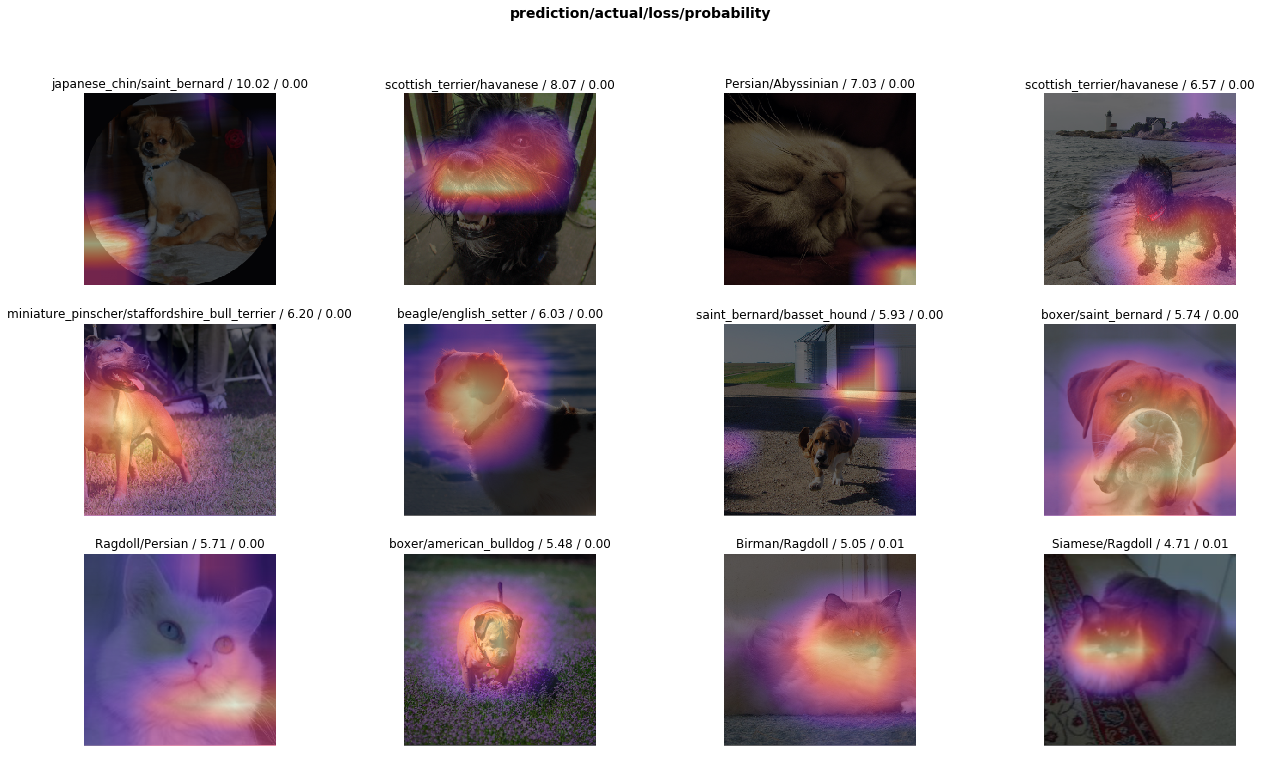

In [86]:
interp.plot_top_losses(12, figsize=(22,12))

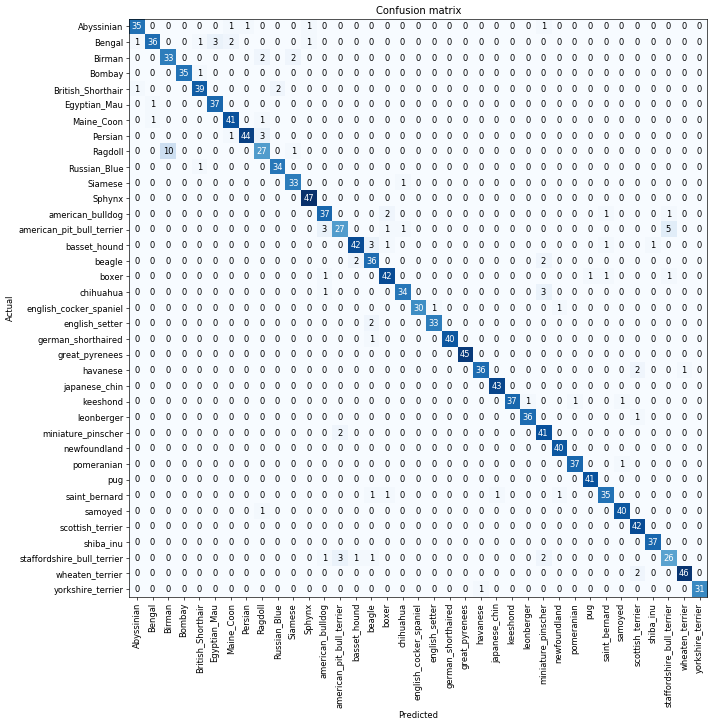

In [77]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [90]:
interp.most_confused()[:5]

[('Ragdoll', 'Birman', 10),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Persian', 'Ragdoll', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3)]

## DenseNet

In [91]:
learn = cnn_learner(db, models.densenet169, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/jupyter/.torch/models/densenet169-b2777c0a.pth
57365526it [00:01, 41797655.59it/s]


In [92]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


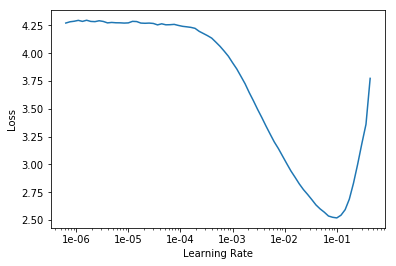

In [93]:
learn.recorder.plot()

In [95]:
lr = 8e-3

In [96]:
learn.fit_one_cycle(4, lr)

In [97]:
learn.save('dn169-stage1')

In [98]:
learn.unfreeze()

In [99]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


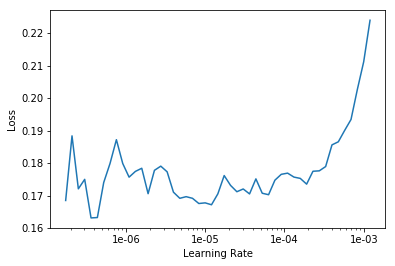

In [102]:
learn.recorder.plot(skip_start=3)

In [104]:
learn.fit_one_cycle(6, max_lr=slice(1e-6, lr/10))

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, lr/100))